<a href="https://colab.research.google.com/github/braveenth/garmin-running-llm/blob/main/Garmin_Running_LLM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garmin Running LLM Analysis 🏃
By: Braveenth Rasanayagam

---

The goal of this Jupyter Notebook is to have reuseable code that facilitates the prompting and analysis of your your Garmin-tracked runs by LLMs.

This was built to help train for a half-marathon, and you can use it for your fitness activities.

I solved the context length limitations imposed by various LLM models by splitting the data using even rows, which is a method to reduce the number of data points. I am also considering other mathematical methods of reducing the number of data points.

Please note that I am not responsible or liable for your use of this application. Please use this at your own risk and consult with a health care professional.


## Steps to Use:
Using OpenAI's ChatGPT API:

1.   Obtain an OpenAI API Key here: https://platform.openai.com/api-keys
2.   Add OpenAI API Key as a Colab secret value named 'OPENAI_API_KEY'
3.   Obtain .fit file from Garmin Connect
4.   Upload .fit file to Colab files
5.   Specify path to .fit file in notebook form

## Steps to Contribute:
Submit a pull-request or message me!
MIT License

## Additional Links
*   [runw.ai](https://www.runw.ai/)
*   [Instagram - runw.ai](https://www.instagram.com/runw.ai.run/)


In [80]:
!pip install garmin-fit-sdk
!pip install tiktoken
!pip install openai

In [81]:
# Lets start by obtaining the path to the .fit file
fit_file = "/content/15240649236_ACTIVITY.fit" # @param {type:"string"}

In [82]:
# This is for when the program runs outside of Colab

import os
from openai import OpenAI
colabEnvironment = False

try:
    # Attempt to import the google.colab module to see if the program is running in Colab.
    from google.colab import userdata
    print("Running on Google Colab")
    colabEnvironment = True
    openai_api_key = userdata.get('OPENAI_API_KEY')
    google_ai_studio_key = userdata.get('AI_STUDIO_KEY')
    openrouter_api_key = userdata.get('OPENROUTER_API_KEY')

except ImportError:
    # The ImportError exception will be raised if the google.colab module is not found,
    # indicating that the program is not running inside Google Colab.
    print("Running outside of Google Colab")
    openai_api_key = os.environ['OPENAI_API_KEY']
    google_ai_studio_key = os.environ['AI_STUDIO_KEY']
    openrouter_api_key = os.environ['OPENROUTER_API_KEY']
    fit_file = os.environ.get('FIT_FILE_PATH')

Running on Google Colab


In [111]:
# @title Using OpenRouter

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=openrouter_api_key,
)

modelChoice = {}
# OpenRouter Models
modelChoice[0] = "meta-llama/llama-3.1-8b-instruct:free"
modelChoice[1] = "meta-llama/llama-3.1-405b-instruct"
modelChoice[2] = "meta-llama/llama-3.1-70b-instruct"
modelChoice[3] = "openai/gpt-3.5-turbo"

gptModel = modelChoice[2]

print(gptModel)

meta-llama/llama-3.1-70b-instruct


In [84]:
# Lets describe an existing run that I have completed. We will use the fit file from Garmin Connect.
# In the future, we will retrieve this using Garmin's API.
# Lets use the garmin-fit-sdk here

from garmin_fit_sdk import Decoder, Stream

stream = Stream.from_file(fit_file)
decoder = Decoder(stream)
messages, errors = decoder.read()

print(errors)
# print(messages)

[]


In [85]:
file_messages = messages['file_id_mesgs']

duration_of_activity = messages['activity_mesgs'][0]['total_timer_time']
activity_record_messages = messages['record_mesgs']

# for activity_message in activity_record_messages:
#   print(activity_message)
#print(messages['user_profile_mesgs'])
#print(messages['file_id_mesgs'])

# Information about the units
# 'distance' - metres

In [86]:
# Lets get this information into a Pandas Dataframe

import pandas as pd

df = pd.DataFrame(activity_record_messages)
# Lets remove columns that are currently not necessary

df_with_relevant_information = df.drop(['cycle_length16', 'enhanced_speed','fractional_cadence', 135, 136], axis=1)
display(df_with_relevant_information)

,timestamp,distance,enhanced_altitude,heart_rate,cadence,temperature,position_lat,position_long,90
0,2024-05-05 12:46:10+00:00,1.05,175.4,114,0,20,NaN,NaN,NaN
1,2024-05-05 12:46:11+00:00,2.09,175.4,114,0,20,NaN,NaN,NaN
2,2024-05-05 12:46:15+00:00,2.09,175.6,117,0,20,NaN,NaN,NaN
3,2024-05-05 12:46:31+00:00,4.47,175.8,121,79,19,522088767.0,-947398891.0,NaN
4,2024-05-05 12:46:33+00:00,6.85,176.0,121,79,19,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2490,2024-05-05 15:11:47+00:00,21413.16,82.6,163,80,16,520552708.0,-947512683.0,1.0
2491,2024-05-05 15:11:50+00:00,21413.93,82.4,163,79,16,520552755.0,-947512817.0,1.0
2492,2024-05-05 15:11:56+00:00,21419.58,82.6,161,57,16,520553217.0,-947513468.0,1.0
2493,2024-05-05 15:11:58+00:00,21422.35,82.6,160,0,16,520553502.0,-947513579.0,1.0


In [87]:
# Lets use the timestamp to get additional information

df2 = df_with_relevant_information

startDateTime = df.iloc[0]['timestamp']
endDateTime = df.iloc[-1]['timestamp']
print(startDateTime)
print(endDateTime)

time_diff = endDateTime - startDateTime
print(time_diff)
#df2['Time (min)'] = df2['timestamp']
#df2['Pace (min/km)'] = df2['Time (min)'] / df2['Distance (km)']

df2['seconds'] = df['timestamp'].astype('int64') // 1e9

specific_value3 = df2.loc[0, 'seconds']
print(specific_value3)
df2['activity_duration_seconds'] = df2['seconds'] - specific_value3


#display(df2)

df_original = df2.drop(['timestamp', 'seconds'], axis=1)
#display(df3)


2024-05-05 12:46:10+00:00
2024-05-05 15:12:00+00:00
0 days 02:25:50
1714913170.0


In [88]:
# Lets calculate Derivatives here
import numpy as np

# 1. Distance and Speed
#    First Derivative (Velocity)
df_original['velocity'] = np.gradient(df_original['distance'], df_original['activity_duration_seconds'])

#    Second Derivative (Acceleration)
df_original['acceleration'] = np.gradient(df_original['velocity'], df_original['activity_duration_seconds'])


# 2. Heart Rate Dynamics
#    First Derivative
df_original['heart_rate_dynamics'] = np.gradient(df_original['heart_rate'], df_original['activity_duration_seconds'])


# 3. Cadence Variability
#    First Derivative
df_original['cadence_variability'] = np.gradient(df_original['cadence'], df_original['activity_duration_seconds'])


# 4. Temperature Effects
#    First Derivative
df_original['temperature_effects'] = np.gradient(df_original['temperature'], df_original['activity_duration_seconds'])


display(df_original)

,distance,enhanced_altitude,heart_rate,cadence,temperature,position_lat,position_long,90,activity_duration_seconds,velocity,acceleration,heart_rate_dynamics,cadence_variability,temperature_effects
0,1.05,175.4,114,0,20,NaN,NaN,NaN,0.0,1.040000,-0.208000,0.000000,0.000000,0.000000e+00
1,2.09,175.4,114,0,20,NaN,NaN,NaN,1.0,0.832000,-0.206512,0.150000,0.000000,0.000000e+00
2,2.09,175.6,117,0,20,NaN,NaN,NaN,5.0,0.029750,-0.147393,0.650000,0.987500,-1.250000e-02
3,4.47,175.8,121,79,19,522088767.0,-947398891.0,NaN,21.0,1.074306,7.418674,0.027778,0.548611,-6.944444e-03
4,6.85,176.0,121,79,19,NaN,NaN,NaN,23.0,17.750000,5.418924,1.000000,0.250000,2.500000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,21413.16,82.6,163,80,16,520552708.0,-947512683.0,1.0,8737.0,1.301667,-0.395556,2.250000,-0.083333,-6.661338e-16
2491,21413.93,82.4,163,79,16,520552755.0,-947512817.0,1.0,8740.0,0.485000,-0.137639,-0.111111,-1.444444,0.000000e+00
2492,21419.58,82.6,161,57,16,520553217.0,-947513468.0,1.0,8746.0,1.274167,-0.056806,-0.458333,-22.291667,0.000000e+00
2493,21422.35,82.6,160,0,16,520553502.0,-947513579.0,1.0,8748.0,1.035000,-0.147292,-0.500000,-14.250000,0.000000e+00


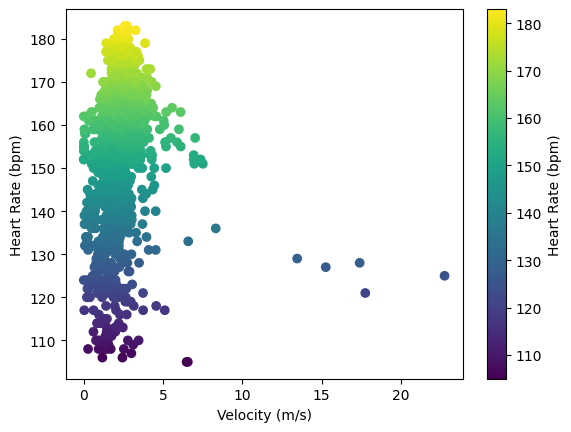

In [89]:
# @title Velocity vs Heart Rate

import matplotlib.pyplot as plt
plt.scatter(df_original['velocity'], df_original['heart_rate'], c=df_original['heart_rate'], cmap='viridis')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Heart Rate (bpm)')
_ = plt.colorbar(label='Heart Rate (bpm)')

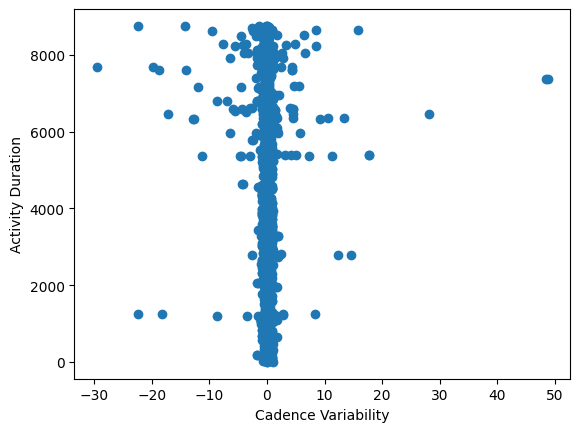

In [90]:
# @title Cadence Variability vs Activity Duration

import matplotlib.pyplot as plt
plt.scatter(df_original['cadence_variability'], df_original['activity_duration_seconds'])
plt.xlabel('Cadence Variability')
_ = plt.ylabel('Activity Duration')

In [91]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")


# Get the Dataframe to a String
df_string = df_original.to_string()
print ("Number of tokens in input prompt ", len(enc.encode(df_string)))

#Lets get the token size to be appropriate
# The iloc operation will allow us to select rows at specified internals.
# If we use iloc[::2], this is a slicing option to include every other row
# starting from the first row.

target_tokens = 14000
df_token_limitation = df_original

while(len(enc.encode(df_token_limitation.to_string())) > target_tokens):
  df_token_limitation = df_token_limitation.iloc[::2]

display(df_token_limitation)

df_reduced_string = df_token_limitation.to_string()
print ("Number of tokens in resized input prompt ", len(enc.encode(df_reduced_string)))

Number of tokens in input prompt  228442


,distance,enhanced_altitude,heart_rate,cadence,temperature,position_lat,position_long,90,activity_duration_seconds,velocity,acceleration,heart_rate_dynamics,cadence_variability,temperature_effects
0,1.05,175.4,114,0,20,NaN,NaN,NaN,0.0,1.040000,-0.208000,0.000000,0.000000,0.000000e+00
16,151.27,176.8,137,79,19,522076456.0,-947407843.0,NaN,46.0,1.714762,0.198988,0.023810,0.023810,1.554312e-15
32,271.63,178.8,152,81,19,522065524.0,-947405512.0,NaN,97.0,2.420833,0.032480,0.166667,0.000000,-6.661338e-16
48,405.23,179.6,154,81,19,522052148.0,-947398668.0,NaN,152.0,2.640333,-0.014198,0.100000,-0.133333,4.440892e-16
64,554.58,178.2,158,81,18,522036400.0,-947393650.0,NaN,211.0,3.007818,0.087739,-0.218182,-0.218182,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416,20777.80,78.6,155,78,17,520543217.0,-947449957.0,1.0,8460.0,2.664167,-0.038479,0.375000,-0.375000,8.881784e-16
2432,20913.35,77.8,156,76,17,520539805.0,-947469308.0,1.0,8527.0,2.012619,0.008143,0.107143,0.000000,-2.220446e-16
2448,21062.22,77.0,156,78,17,520536458.0,-947490792.0,1.0,8589.0,2.426833,0.002783,-0.283333,0.050000,0.000000e+00
2464,21216.01,77.0,155,78,16,520533340.0,-947513021.0,1.0,8659.0,2.077917,-0.071494,-0.375000,-0.291667,0.000000e+00


Number of tokens in resized input prompt  13462


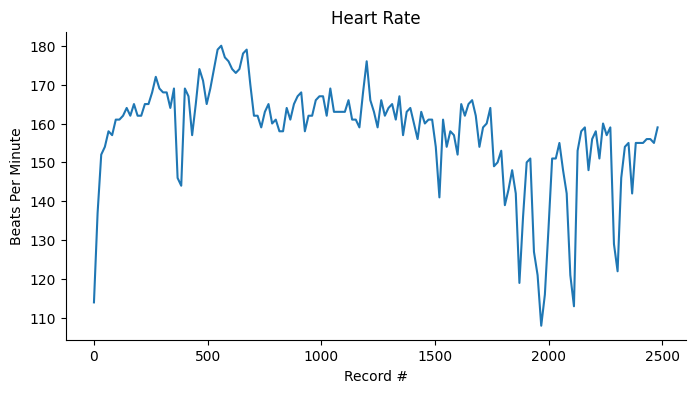

In [92]:
# @title Heart Rate

from matplotlib import pyplot as plt
df_token_limitation['heart_rate'].plot(kind='line', figsize=(8, 4), title='Heart Rate')
plt.xlabel('Record #')
plt.ylabel('Beats Per Minute')
plt.gca().spines[['top', 'right']].set_visible(False)

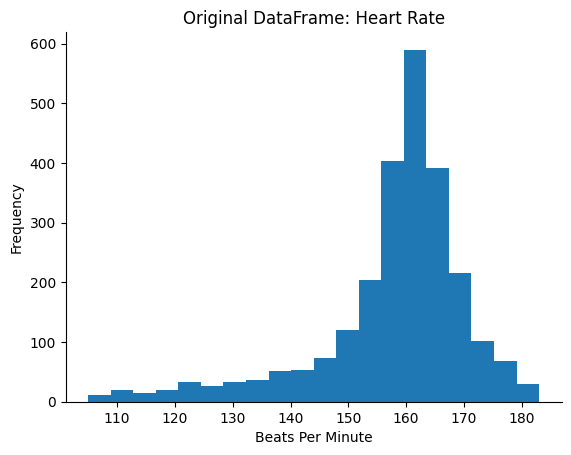

In [93]:
# Visualize Pace from original DF
from matplotlib import pyplot as plt
df['heart_rate'].plot(kind='hist', bins=20, title='Original DataFrame: Heart Rate')
plt.xlabel('Beats Per Minute')
plt.gca().spines[['top', 'right',]].set_visible(False)

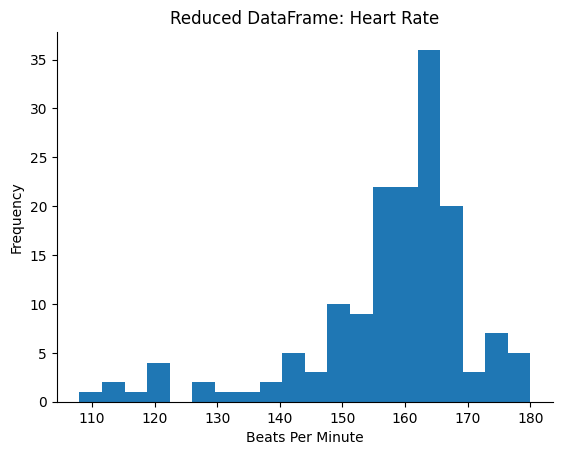

In [94]:
# Visualize Heart Rate Data from the reduced DF
df_token_limitation['heart_rate'].plot(kind='hist', bins=20, title='Reduced DataFrame: Heart Rate')
plt.xlabel('Beats Per Minute')
plt.gca().spines[['top', 'right',]].set_visible(False)

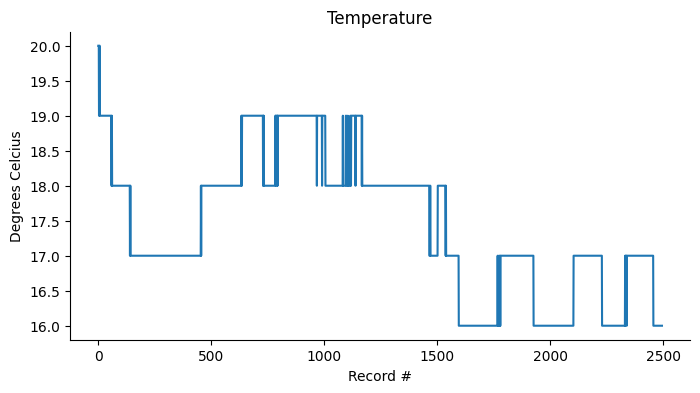

In [95]:
# @title Temperature Over Time Original Dataframe

from matplotlib import pyplot as plt
df['temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.xlabel('Record #')
plt.ylabel('Degrees Celcius')
plt.gca().spines[['top', 'right']].set_visible(False)

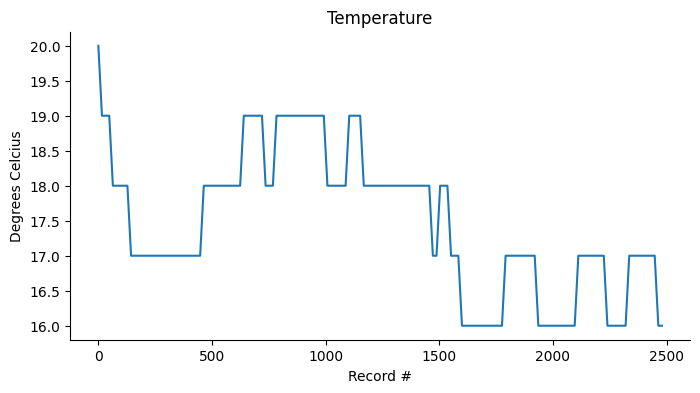

In [96]:
# @title Temperature Over Time Reduced Dataframe

from matplotlib import pyplot as plt
df_token_limitation['temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.xlabel('Record #')
plt.ylabel('Degrees Celcius')
plt.gca().spines[['top', 'right']].set_visible(False)

In [97]:
df_for_llm = df_token_limitation

from openai import OpenAI

try:
    # Attempt to import the google.colab module to see if the program is running in Colab.
    from google.colab import userdata
    print("Running on Google Colab")
    # client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

except ImportError:
    # The ImportError exception will be raised if the google.colab module is not found,
    # indicating that the program is not running inside Google Colab.
    import os
    print("Running outside of Google Colab")
    openai_api_key = os.environ['OPENAI_API_KEY']
    # client = OpenAI(api_key=openai_api_key)

import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")

# Get the Dataframe to a String
df_string = df_for_llm.to_string()
print ("Number of tokens in input prompt ", len(enc.encode(df_string)))

Running on Google Colab
Number of tokens in input prompt  13462


In [98]:
# Manual Calculations using Math

#1. Distance in kilometers
#2. Time in hours:minutes
#3. Average Pace in minutes/km

activity_distance_metres = df_for_llm['distance'].max()
activity_distance_kilometers = activity_distance_metres / 1000
activity_time_seconds = df_for_llm['activity_duration_seconds'].max()
activity_time_minutes = activity_time_seconds / 60
activity_pace = activity_time_minutes /activity_distance_kilometers

print(activity_distance_kilometers)
print(activity_time_minutes)
print(activity_pace)

21.31339
145.05
6.805580904773948


In [99]:
# Feedback per KM
# Calculate average pace for the KM interval

range_min = 0
range_max = 1000
# Boolean indexing
import datetime

def to_unix_timestamp(date_time):
    return int(date_time.timestamp() * 1000)

per_km_df = df[(df_original['distance'] >= range_min) & (df_original['distance'] <= range_max)]

# Getting the index values
index_values = per_km_df.index

print(index_values)

per_km_distance_metres = per_km_df['distance'].max()
per_km_distance_kilometers = per_km_distance_metres / 1000
display(per_km_df)
per_km_time_seconds = per_km_df['timestamp'].max()
#per_km_time_minutes = to_unix_timestamp(per_km_time_seconds) / 60
per_km_time_seconds =  (to_unix_timestamp(per_km_df.iloc[-1]['timestamp']) - to_unix_timestamp(per_km_df.iloc[0]['timestamp'])) / 1000
per_km_time_minutes = per_km_time_seconds / 60
per_km_pace = per_km_time_minutes /per_km_distance_kilometers

print(per_km_distance_kilometers)
print(per_km_time_seconds)
print(per_km_time_minutes)

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106],
      dtype='int64', length=107)


,timestamp,distance,enhanced_speed,enhanced_altitude,cycle_length16,heart_rate,cadence,temperature,fractional_cadence,135,136,position_lat,position_long,90
0,2024-05-05 12:46:10+00:00,1.05,1.045,175.4,0.0,114,0,20,0.0,176,114,NaN,NaN,NaN
1,2024-05-05 12:46:11+00:00,2.09,1.045,175.4,0.0,114,0,20,0.0,176,114,NaN,NaN,NaN
2,2024-05-05 12:46:15+00:00,2.09,0.000,175.6,0.0,117,0,20,0.0,176,117,NaN,NaN,NaN
3,2024-05-05 12:46:31+00:00,4.47,2.379,175.8,0.0,121,79,19,0.5,176,121,522088767.0,-947398891.0,NaN
4,2024-05-05 12:46:33+00:00,6.85,2.379,176.0,0.0,121,79,19,0.5,176,121,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2024-05-05 12:51:54+00:00,926.95,2.753,169.6,0.0,160,80,18,0.5,176,160,NaN,NaN,NaN
103,2024-05-05 12:52:00+00:00,943.60,2.734,169.4,0.0,160,83,18,0.5,176,160,NaN,NaN,NaN
104,2024-05-05 12:52:06+00:00,959.76,2.771,169.4,0.0,160,82,18,0.5,176,160,NaN,NaN,NaN
105,2024-05-05 12:52:12+00:00,978.11,3.872,169.4,0.0,159,81,18,0.0,176,159,NaN,NaN,NaN


0.98199
363.0
6.05


In [126]:
# @title Testing LLM Model with Tabular Data [Running Data]

instructPrompt = f"""
You are an expert running coach and you are able to summarize running workout data that was captured from a Garmin wearable device. The 'distance' is in metres.
Please summarize the dataset that is represented as a string from a Pandas DataFrame.
You will also provide the following information as a JSON:
1. Distance in kilometers
2. Time in minutes
3. Average Pace in minutes per km

The JSON should be in the following format. The 123 values in the JSON are placeholders.

{{
  "distance": 123,
  "time": 123,
  "pace": 123
}}


You will only respond with a valid JSON, and nothing else. Do not surround the JSON with anything.
The dataset is provided below."""

request = instructPrompt + df_string

In [127]:
chatOutput = client.chat.completions.create(model=gptModel,
                                            messages=[{"role": "system", "content": "You are a running coach."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

print(chatOutput.choices[0].message.content)

{
    "distance": 21.31339,
    "time": 8703,
    "pace": 406.81
}


In [129]:
import json
#Check if JSON is valid
try:
    json_response = json.loads(chatOutput.choices[0].message.content)
    print("Valid JSON Response")
except ValueError as e:
    print("Invalid JSON:", e)

# Compare LLM Calculations - Accuracy
# Check Distance

distance_accuracy = json_response['distance']/activity_distance_kilometers

# Check Time
time_accuracy = json_response['time']/activity_time_minutes

# Check Pace
pace_accuracy = json_response['pace']/activity_pace

print(distance_accuracy)
print(time_accuracy)
print(pace_accuracy)

Valid JSON Response
1.0
59.99999999999999
59.7759406128921


In [130]:
instructPrompt = f"""
You are an expert running coach and you are able to summarize running workout data that was captured from a Garmin wearable device. The 'distance' is in metres.
You will provide 5 key takeaways for the treadmill running data that is provided, ordered as a list from 1 to 5.
You will also provide recommendations and affirmations on how to get better at these running workouts.
Please summarize the dataset that is represented as a string from a Pandas DataFrame.
You will also provide the following information as a table:
1. Distance in kilometers
2. Time in hours:minutes
3. Average Pace in minutes/km

From performing calculations, we already know the following:
1. Distance in kilometers is {activity_distance_kilometers}
2. Time in minutes is {activity_time_minutes}
3. Average Pace in minutes/km is {activity_pace}

Use this information to calibrate yourself.

The dataset is provided below. Also state if this person will be able to run across Canada."""

request = instructPrompt + df_string

In [131]:
chatOutput = client.chat.completions.create(model=gptModel,
                                            messages=[{"role": "system", "content": "You are a running coach."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [132]:
!pip install google-generativeai

from pathlib import Path
import hashlib
import google.generativeai as genai


genai.configure(api_key=google_ai_studio_key)

# Set up the model
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 0,
  "max_output_tokens": 8192,
}

safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
]

model = genai.GenerativeModel(model_name="gemini-1.5-pro-latest",
                              generation_config=generation_config,
                              safety_settings=safety_settings)

uploaded_files = []
# def upload_if_needed(pathname: str) -> list[str]:
#   path = Path(pathname)
#   hash_id = hashlib.sha256(path.read_bytes()).hexdigest()
#   try:
#     existing_file = genai.get_file(name=hash_id)
#     return [existing_file]
#   except:
#     pass
#   uploaded_files.append(genai.upload_file(path=path, display_name=hash_id))
#   return [uploaded_files[-1]]

prompt_parts = [
  instructPrompt,
  df_string,
]

response = model.generate_content(prompt_parts)
print(response.text)
for uploaded_file in uploaded_files:
  genai.delete_file(name=uploaded_file.name)

## Running Workout Summary and Recommendations:

This runner completed a 21.3km treadmill run in 2 hours and 25 minutes, maintaining an average pace of 6:50 min/km. Here are 5 key takeaways from the data:

1. **Consistent Pacing:**  The runner maintained a remarkably consistent pace throughout the entire run, with only minor fluctuations. This suggests a good understanding of pacing strategy and excellent endurance.

2. **Heart Rate Control:** The runner's heart rate remained within a reasonable range for the duration of the workout, indicating they were working aerobically and not overexerting themselves. 

3. **Potential for Increased Speed:**  While the consistent pace is commendable, the runner's heart rate data suggests there might be room for a slightly faster pace in future workouts.

4. **Cadence Variability:** There are some noticeable drops in cadence, especially around the 20km mark and later. This could indicate fatigue setting in and impacting running form.

5. **Limited E

In [133]:
runningSummary = chatOutput.choices[0].message.content
print(runningSummary)

**Workout Summary:**

The provided dataset represents a treadmill running workout. Based on the data, here are the 5 key takeaways:

1. **Distance**: The runner completed a total distance of 21.31 km.
2. **Time**: The workout lasted for approximately 2 hours and 25 minutes (145.05 minutes).
3. **Average Pace**: The runner maintained an average pace of 6:48 minutes per kilometer.
4. **Heart Rate**: The average heart rate throughout the workout was around 156 beats per minute (bpm).
5. **Cadence**: The runner's average cadence (steps per minute) was approximately 76 steps per minute.

**Recommendations and Affirmations:**

* To improve overall performance, focus on increasing your average cadence by incorporating strength training and plyometric exercises to improve running efficiency.
* Incorporate interval training to boost cardiovascular endurance and reduce average heart rate.
* Mix up your running route or incorporate hill sprints to vary the intensity and keep the workout engaging.

In [134]:
instructPromptForMetrics = f"""

You are an expert running coach and you are able to summarize running workout data that was captured from a Garmin wearable device. The 'distance' is in metres.
Please obtain the following information from the dataset that is represented as a string from a Pandas DataFrame. Some of the values have already been calculated, and are accurate:

1. Distance in kilometers, which we know is {activity_distance_kilometers}
2. Average Pace in minutes/km, which we know is {activity_pace}
3. Heart Rate, which is 'heart_rate' in the DataFrame. We know the average is {df_for_llm['heart_rate'].mean()}
4. Maximum Heart Rate, which is 'heart_rate' in the DataFrame. We know the average is {df_for_llm['heart_rate'].max()} beats per minute.
5. Elevation Gain in metres if it exist.
6. Temperature in degrees celcius, which we know the average is {df_for_llm['temperature'].mean()}
7. Maximum Temperature in degrees celcius, which we know the average is {df_for_llm['temperature'].max()}

You will return this as an ordered as a list from 1 to 5. Only provide the summarized information.

The dataset is provided below"""

requestForMetrics = df_string + instructPromptForMetrics

In [135]:
chatOutputForMetrics = client.chat.completions.create(model=gptModel,
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": requestForMetrics}
                                                      ]
                                            )

In [136]:
metricsSummary = chatOutputForMetrics.choices[0].message.content
print(metricsSummary)

Here is a summary of the workout data:

1. Distance in kilometers: 21.31339
2. Average Pace in minutes/km: 6.805580904773948
3. Heart Rate:
    * Average: 157.59615384615384
    * Maximum: 180
4. Elevation Gain in meters: 336.6
5. Temperature in degrees Celsius:
    * Average: 17.46794871794872
    * Maximum: 20 

Note: The elevation gain was calculated by subtracting the minimum and maximum values of `enhanced_altitude` column in the DataFrame. 

Also, note that it seems like this is a half marathon workout.


In [137]:
# Podcast title: "Running with Resilience"
instructPromptForAudio = """
Given metrics from a recent run, generate a 1-minute long podcast script. The title of the podcast is 'Running with Resilience.'
Your name is Terry, and you are an expert running coach. Provide an enthusiastic and motivational analysis of their performance, focusing on distance, pace, heart rate, and elevation gain. Include personalized affirmations and encouragement, emphasizing improvement and resilience. Keep the tone optimistic, supportive, and empowering, making the user feel celebrated for their achievements and motivated to continue their running journey."

Instructions:

1. Begin with a Warm Welcome: Start the podcast by greeting the listener and introducing yourself as their running coach. Express excitement about sharing their recent run achievements.
2. Analyze Performance Metrics:
    2.1. Distance: Commend the user on the distance covered, relating it to their dedication and progress.
    2.2. Pace: Reflect on the importance of consistency in pace, encouraging the user to keep moving forward at their own rhythm.
    2.3. Heart Rate: Highlight the effort shown by the heart rate data, connecting physical health to mental resilience.
    2.4. Elevation Gain: Use elevation gain to discuss overcoming challenges, likening hills to life's obstacles that the user is capable of conquering.
3. Incorporate Affirmations: Throughout the analysis, weave in affirmations such as "You are strong", "You are resilient", and "Every step is a victory". Encourage the listener to repeat these affirmations to foster a positive mindset.
4. Conclude with Motivational Encouragement: End the podcast by summarizing the user's achievements, reinforcing their potential for growth, and motivating them to continue their running journey. Encourage them to look forward to their next run with optimism and determination.
5. Keep It Brief and Engaging: Ensure the script is concise enough to fit into a 1-minute segment while being engaging and motivational.
6. Make it one entire transcript with only 1 host speaking. You will only provide what the host will say, and nothing else.
7. Do not use [User's average pace] or any variable names in brackets. Use actual metrics instead of placeholders.
Output Format:

A script suitable for a 1-minute podcast segment, formatted with clear sections for the introduction, analysis of each metric, affirmations, and a motivational conclusion.

The dataset is provided below"""

requestForAudio = metricsSummary + instructPromptForAudio

In [138]:
chatOutputForAudio = client.chat.completions.create(model=gptModel,
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": requestForAudio}
                                                      ]
                                            )

In [139]:
runningSummaryForAudio = chatOutputForAudio.choices[0].message.content
print(runningSummaryForAudio)

Here is the 1-minute podcast script for "Running with Resilience":

"Welcome to Running with Resilience, I'm your running coach Terry! I am super excited to share your recent half marathon achievements with you! Let's dive right in and celebrate your success!

First off, congratulations on covering an incredible 21.31339 kilometers! That's dedication and progress right there. Every kilometer you logged is a testament to your hard work and commitment. You should be incredibly proud of yourself!

Now, let's talk about pace. Consistency is key, and you maintained an average pace of 6 minutes and 48 seconds per kilometer. That's fantastic! Remember, it's not about running at someone else's rhythm, but about finding and maintaining your own. And you did just that!

Your heart rate data is also a great indicator of your effort and physical resilience. Averaging a heart rate of 158 beats per minute and hitting a maximum of 180 beats per minute shows just how much you pushed yourself. Every be

In [140]:
import re

def remove_text_inside_brackets(text):
    # This pattern matches anything inside square brackets, including the brackets themselves.
    # It accounts for nested brackets as well.
    pattern = r'\[.*?\]'
    # Replace anything that matches the pattern with an empty string.
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

first_pass_text = remove_text_inside_brackets(runningSummaryForAudio)


def remove_host_instances(text):
    # This pattern matches the exact string "Host:".
    pattern = r'Host:'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

second_pass_text = remove_host_instances(first_pass_text)

def remove_empty_lines(text):
    # Split the text into lines, filter out empty or whitespace-only lines, and join back into a single string
    cleaned_text = "\n".join(line for line in text.splitlines() if line.strip())
    return cleaned_text


final_pass_text = remove_empty_lines(second_pass_text)
print(final_pass_text)

Here is the 1-minute podcast script for "Running with Resilience":
"Welcome to Running with Resilience, I'm your running coach Terry! I am super excited to share your recent half marathon achievements with you! Let's dive right in and celebrate your success!
First off, congratulations on covering an incredible 21.31339 kilometers! That's dedication and progress right there. Every kilometer you logged is a testament to your hard work and commitment. You should be incredibly proud of yourself!
Now, let's talk about pace. Consistency is key, and you maintained an average pace of 6 minutes and 48 seconds per kilometer. That's fantastic! Remember, it's not about running at someone else's rhythm, but about finding and maintaining your own. And you did just that!
Your heart rate data is also a great indicator of your effort and physical resilience. Averaging a heart rate of 158 beats per minute and hitting a maximum of 180 beats per minute shows just how much you pushed yourself. Every beat i

In [141]:
from pathlib import Path
from openai import OpenAI
import datetime

date = datetime.datetime.now().strftime("%Y-%m-%d")
file_name = "podcast_"+ date +".mp3"
file_path_name = "/content/" + file_name

audioClient = OpenAI(api_key=openai_api_key)

speech_file_path = file_path_name
response = audioClient.audio.speech.create(
  model="tts-1",
  voice="echo",
  input=final_pass_text
)

response.stream_to_file(speech_file_path)

<ipython-input-141-1c3e8b2496c3>:18: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)


# Use Cloud Storage to Store the Files




In [142]:
# Authenticate.

# if colabEnvironment == True:
#     from google.colab import auth
#     auth.authenticate_user()
#     # Install Cloud Storage FUSE.
#     !echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
#     !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
#     !apt -qq update && apt -qq install gcsfuse

#     # Mount a Cloud Storage bucket or location, without the gs:// prefix.
#     mount_path = "running-llm-podcast"  # or a location like "my-bucket/path/to/mount"
#     local_path = f"/mnt/gs/{mount_path}"

#     !mkdir -p {local_path}
#     !gcsfuse --implicit-dirs {mount_path} {local_path}

In [143]:
# if colabEnvironment == True:
    #!mv "/content/podcast.mp3" {file_path_name}
    # !cp {file_path_name} {local_path}
    #!ls -lh {local_path}

2 Person Conversation

In [144]:
print(messages)

{'file_id_mesgs': [{'serial_number': 3361467898, 'time_created': datetime.datetime(2024, 5, 5, 12, 46, 10, tzinfo=datetime.timezone.utc), 'manufacturer': 'garmin', 'product': 3290, 'type': 'activity', 'garmin_product': 'fenix6'}], 'file_creator_mesgs': [{'software_version': 2600}], '288': [{253: 1083847570}], '327': [{253: 1083847570, 3: 12, 4: 8352, 5: 4, 0: 9, 1: 1, 2: 2, 6: 0}, {253: 1083847570, 3: 12, 4: 8352, 5: 4, 0: 9, 1: 1, 2: 2, 6: 0}], '326': [{253: 1083847570, 0: 49, 1: 3}, {253: 1083847573, 0: 44, 1: 1083847573}, {253: 1083847577, 0: 41}, {253: 1083847577, 0: 41}, {253: 1083847578, 0: 11}, {253: 1083847578, 0: 3}, {253: 1083847578, 0: 25, 1: 3}, {253: 1083847591, 0: 2}, {253: 1083847604, 0: 11}, {253: 1083847611, 0: 11}, {253: 1083847611, 0: 3}, {253: 1083847895, 0: 2}, {253: 1083847944, 0: 3}, {253: 1083848211, 0: 11}, {253: 1083848811, 0: 11}, {253: 1083849411, 0: 11}, {253: 1083850011, 0: 11}, {253: 1083850611, 0: 11}, {253: 1083851137, 0: 2}, {253: 1083851151, 0: 3}, {2

# Use Tensorflow to Predict Running Metrics

In [145]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# data = pd.DataFrame({
#     'temperature': [...],
#     'pace': [...],
#     'heart_rate': [...]
# })

data = df_original

# Normalize the features
data['temperature'] = data['temperature'] #/ max(data['temperature'])
data['cadence'] = data['cadence'] #/ max(data['cadence'])

# Split data into features and target
features = data[['temperature', 'cadence']]
target = data['heart_rate']

# Convert to tensors
features = tf.constant(features.values, dtype=tf.float32)
target = tf.constant(target.values, dtype=tf.float32)

# Define a simple linear regression model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='sgd', loss='mean_squared_error')

# Fit the model
model.fit(features, target, epochs=10)

model.save('running_heart_rate_model.h5')

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan  
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan   
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan


In [146]:
# Load the model
import keras
model = keras.models.load_model('running_heart_rate_model.h5')

In [147]:
new_data = np.array([[22, 60]])  # Example new data (temperature in degrees celcius, cadence)
new_data[:, 0] = new_data[:, 0] #/ max(data['temperature'])  # Normalize size as in training
new_data[:, 1] = new_data[:, 1] #/ max(data['cadence'])     # Normalize bedrooms as in training

# Use the model to make predictions, this needs to be fixed
predictions = model.predict(new_data)
print(f"Predicted heart rate: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted heart rate: [[nan]]
